<a href="https://colab.research.google.com/github/pure-sky/ED-Net/blob/main/Fine_tuning_MaskFormerForInstanceSegmentation_on_semantic_covid1018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune MaskFormer for semantic segmentation

In this notebook, we'll show how to fine-tune the model on a semantic segmentation dataset. In semantic segmentation, the goal for the model is to segment general semantic categories in an image, like "building", "people", "sky". No distinction is made between individual instances of a certain category, i.e. we just come up with one mask for the "people" category for instance, not for the individual persons.

Make sure to run this notebook on a GPU.

## Set-up environment

First, we install the necessary libraries. 🤗, what else? Oh yes we'll also use [Albumentations](https://albumentations.ai/), for some data augmentation to make the model more robust. You can of course use any data augmentation library of your choice.

In [21]:
!wget https://www.dropbox.com/scl/fi/6h8ncl80j2b0g84619v0f/TrainingSet.zip?rlkey=2s4t6l4dsl6t0smm48z2fp1m5&dl=0
!wget https://www.dropbox.com/s/icuwmarhs9m85pn/TestingSet.zip?dl=0
!mv TrainingSet.zip?rlkey=2s4t6l4dsl6t0smm48z2fp1m5 TrainingSet.zip
!mv TestingSet.zip?dl=0 TestingSet.zip

--2023-08-03 11:13:54--  https://www.dropbox.com/scl/fi/6h8ncl80j2b0g84619v0f/TrainingSet.zip?rlkey=2s4t6l4dsl6t0smm48z2fp1m5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/e/scl/fi/6h8ncl80j2b0g84619v0f/TrainingSet.zip?rlkey=2s4t6l4dsl6t0smm48z2fp1m5 [following]
--2023-08-03 11:13:55--  https://www.dropbox.com/e/scl/fi/6h8ncl80j2b0g84619v0f/TrainingSet.zip?rlkey=2s4t6l4dsl6t0smm48z2fp1m5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9781292d7aab5c245598494aca.dl.dropboxusercontent.com/cd/0/get/CBE4B426IHi6ZVYhwpcvc7hm_q6LOxwCYZC4RzopN_nOp--XzXX8rrXE4J4iy4x1ui3HKpe4jJpRbEy76guQznAUqkUZMCPwkr2vH39PotrP0h7NhEzcJGPMshZ2EuUkpJxxVsUYEi8aPqjpOUJTkHRU/file# [following]
--2023-08-03 11:13:55--  https://uc9781292d7aab5

In [ ]:
!unzip /content/TrainingSet.zip
!unzip /content/TestingSet.zip

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.0 MB/s eta 0:00:00


In [2]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.1/519.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.2 MB/s eta 0:00:00


In [3]:
!pip install -q albumentations

In [25]:
import PIL.Image as Image

img = Image.open(gt_paths[0])
img.size

(512, 512)

In [94]:
import numpy as np
j = 0
# load corresponding ground truth segmentation map, which includes a label per pixel
for i in sorted(gt_paths):
  data = np.array(Image.open(i))
  min_val = np.min(data)
  max_val = np.max(data)
  segmentation_map = data / 255
  segmentation_map = segmentation_map.astype(np.uint8)
  if len(np.unique(segmentation_map)) == 1:
    print(i, j)
  j += 1

In [86]:
img = Image.open(gt_paths_test[0])
gt_paths_test[10]

'/content/TestingSet/GT/488.png'

In [87]:
!mv /content/TrainingSet/GT/670.png /content/TestingSet/GT/670.png
!mv /content/TrainingSet/GT/669.png /content/TestingSet/GT/669.png

!mv /content/TrainingSet/Imgs/670.png /content/TestingSet/Imgs/670.png
!mv /content/TrainingSet/Imgs/669.png /content/TestingSet/Imgs/669.png

In [89]:
!mv /content/TestingSet/GT/862.png /content/TrainingSet/GT/862.png
!mv /content/TestingSet/GT/488.png /content/TrainingSet/GT/488.png

!mv /content/TestingSet/Imgs/862.png /content/TrainingSet/Imgs/862.png
!mv /content/TestingSet/Imgs/488.png /content/TrainingSet/Imgs/488.png

mv: cannot stat '/content/TestingSet/GT/862.png': No such file or directory
mv: cannot stat '/content/TestingSet/GT/488.png': No such file or directory
mv: cannot stat '/content/TestingSet/Imgs/862.png': No such file or directory


In [75]:
!rm -rf /content/TrainingSet /content/TestingSet /content/__MACOSX

## Load data

Now let's the dataset from the hub.

"But how can I use my own dataset?" Glad you asked. I wrote a detailed guide for that [here](https://github.com/huggingface/transformers/tree/main/examples/pytorch/semantic-segmentation#note-on-custom-data).

In [91]:
import os
import glob

# 图像和GT的文件夹路径
img_folder = "/content/TrainingSet/Imgs"
gt_folder = "/content/TrainingSet/GT"

# 读取图像路径
img_path1 = glob.glob(os.path.join(img_folder, "*.jpg"))  # 根据实际的图像文件格式进行修改
img_path2 = glob.glob(os.path.join(img_folder, "*.png"))
img_paths = img_path1 + img_path2
# 读取GT路径
gt_paths = glob.glob(os.path.join(gt_folder, "*.png"))  # 根据实际的GT文件格式进行修改

# 打印图像和GT的路径
# print("图像路径：")
# for img_path in img_paths:
#     print(img_path)

# print("GT路径：")
# for gt_path in gt_paths:
#     print(gt_path)
len(gt_paths)

718

In [95]:
from datasets import Dataset, DatasetDict, Image

# your images can of course have a different extension
# semantic segmentation maps are typically stored in the png format
image_paths_train = img_paths
label_paths_train = gt_paths

# same for validation
image_paths_validation = img_paths_test
label_paths_validation = gt_paths_test

def create_dataset(image_paths, label_paths):
    dataset = Dataset.from_dict({"image": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())

    return dataset

# step 1: create Dataset objects
train_dataset = create_dataset(image_paths_train, label_paths_train)
validation_dataset = create_dataset(image_paths_validation, label_paths_validation)

# step 2: create DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "val": validation_dataset,
  }
)

# step 3: push to hub (assumes you have ran the huggingface-cli login command in a terminal/notebook)
#dataset.push_to_hub("name of repo on the hub")

# optionally, you can push to a private repo on the hub
dataset.push_to_hub("covid_718", private=True)

Map:   0%|          | 0/718 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

In [19]:
import json
# simple example
id2label = {0: 'lungfild', 1: 'inf'}
with open('id2label.json', 'w') as fp:
    json.dump(id2label, fp)

# 1

In [1]:
from datasets import load_dataset

dataset = load_dataset("pure-sky/covid_718")

Let's take a look at this dataset in more detail. It consists of 1000 examples:

In [106]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 718
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 300
    })
})

In [97]:
def transforms(examples):
    examples["pixel_values"] = [image.convert("RGB") for image in examples["image"]]
    return examples

In [107]:
dataset['train'] = dataset['train'].map(transforms, remove_columns=["image"], batched=True)

In [28]:
dataset['train'][4]

{'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512>,
 'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>}

# 2

In [2]:
# shuffle + split dataset
dataset = dataset.shuffle(seed=1)
dataset = dataset["train"].train_test_split(test_size=0.2)
train_ds = dataset["train"]
test_ds = dataset["test"]

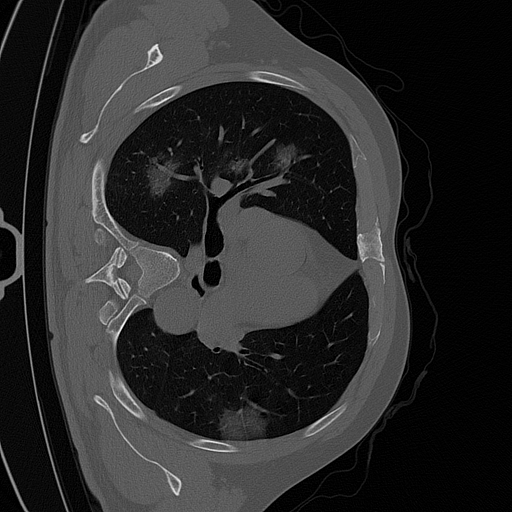

In [5]:
# let's look at one example (images are pretty high resolution)
example = train_ds[1]
image = example['pixel_values']
image

In [6]:
import numpy as np

# load corresponding ground truth segmentation map, which includes a label per pixel
data = np.array(example['label'])
min_val = np.min(data)
max_val = np.max(data)
segmentation_map = (data - min_val) / (max_val - min_val)
segmentation_map = segmentation_map.astype(np.uint8)

Let's look at the semantic categories in this particular example.

In [ ]:
np.unique(segmentation_map)

Cool, but we want to know the actual class names. For that we need the id2label mapping, which is hosted in a repo on the hub.

# 3

In [3]:
from huggingface_hub import hf_hub_download
import json

repo_id = f"pure-sky/covid_718"
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id, filename, repo_type="dataset"), "r"))
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'Otherfild', 1: 'infection'}


In [9]:
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['lungfild', 'infection']


Let's visualize it:

In [12]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    return [[0, 0, 255]]

palette = color_palette()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map - 1 == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

#plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

## Create PyTorch Dataset

Next, we create a standard PyTorch dataset. Each item of the dataset consists of the image and corresponding ground truth segmentation map. We also include the original image + map (before preprocessing) in order to compute metrics like mIoU.

In [110]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['pixel_values'])
        data = np.array(self.dataset[idx]['label'])
        original_segmentation_map = data / 255
        original_segmentation_map = original_segmentation_map.astype(np.uint8)
        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)

        return image, segmentation_map, original_image, original_segmentation_map

The dataset accepts image transformations which can be applied on both the image and the map. Here we use Albumentations, to resize, randomly crop + flip and normalize them. Data augmentation is a widely used technique in computer vision to make the model more robust.

In [111]:
import albumentations as A

ADE_MEAN = np.array([0.485, 0.456, 0.406]) / 255
ADE_STD = np.array([0.229, 0.224, 0.225]) / 255

train_transform = A.Compose([
    A.SmallestMaxSize(max_size=352),
    A.RandomCrop(width=352, height=352),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

test_transform = A.Compose([
    A.Resize(width=352, height=352),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),

])

train_dataset = ImageSegmentationDataset(train_ds, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_ds, transform=test_transform)

In [24]:
image, segmentation_map, _, _ = train_dataset[0]
print(image.shape)
print(segmentation_map.shape)

(3, 352, 352)
(352, 352)


A great way to check that our data augmentations are working well is by denormalizing the pixel values. So here we perform the inverse operation of Albumentations' normalize method and visualize the image:

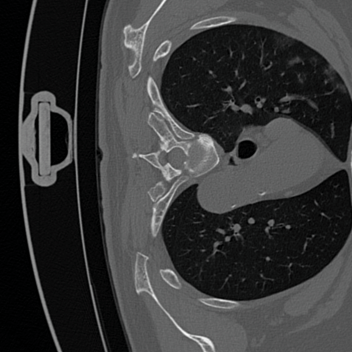

In [25]:
from PIL import Image

unnormalized_image = (image * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

This looks ok. Let's also verify whether the corresponding ground truth map is still ok.

In [26]:
segmentation_map.shape

(352, 352)

In [27]:
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['lungfild', 'infection']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.moveaxis(image, 0, -1) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Ok great!

## Create PyTorch DataLoaders

Next we create PyTorch DataLoaders, which allow us to get batches of the dataset. For that we define a custom so-called "collate function", which PyTorch allows you to do. It's in this function that we'll use the preprocessor of MaskFormer, to turn the images + maps into the format that MaskFormer expects.

It's here that we make the paradigm shift that the MaskFormer authors introduced: the "per-pixel" annotations of the segmentation map will be turned into a set of binary masks and corresponding labels. It's this format on which we can train MaskFormer. MaskFormer namely casts any image segmentation task to this format.

In [112]:
from transformers import MaskFormerImageProcessor

# Create a preprocessor
preprocessor = MaskFormerImageProcessor(ignore_index=0, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

/usr/local/lib/python3.10/dist-packages/transformers/models/maskformer/image_processing_maskformer.py:418: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [113]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    images = inputs[0]
    segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )

    batch["original_images"] = inputs[2]
    batch["original_segmentation_maps"] = inputs[3]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

## Verify data (!!)

Next, it's ALWAYS very important to check whether the data you feed to the model actually makes sense. It's one of the main principles of [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/), if you wanna debug your neural networks.

Let's check the first batch, and its content.

In [14]:
import torch

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([4, 3, 352, 352])
pixel_mask torch.Size([4, 352, 352])
mask_labels torch.Size([1, 352, 352])
class_labels torch.Size([1])
original_images (630, 630, 3)
original_segmentation_maps (630, 630)


In [15]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 352, 352)

Again, let's denormalize an image and see what we got.

In [ ]:
unnormalized_image = (pixel_values * np.array(ADE_STD)[:, None, None]) + np.array(ADE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Let's verify the corresponding binary masks + class labels.

In [17]:
# verify class labels
labels = [id2label[label] for label in batch["class_labels"][0].tolist()]
print(labels)

['infection']


In [18]:
# verify mask labels
batch["mask_labels"][0].shape

torch.Size([1, 352, 352])

In [19]:
def visualize_mask(labels, label_name):
  print("Label:", label_name)
  idx = labels.index(label_name)

  visual_mask = (batch["mask_labels"][0][idx].bool().numpy() * 255).astype(np.uint8)
  return Image.fromarray(visual_mask)

Label: infection


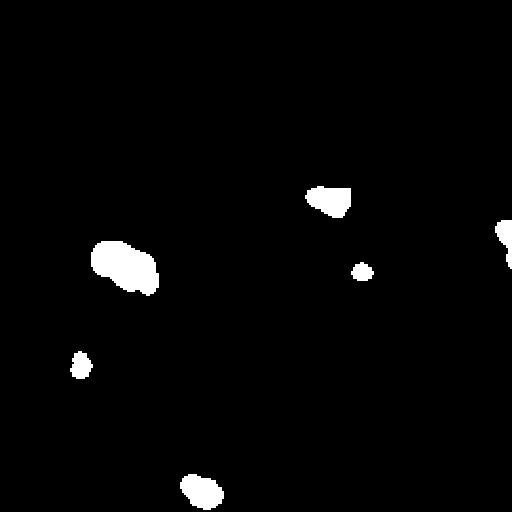

In [30]:
visualize_mask(labels, "infection")

## Define model

Next, we define the model. We equip the model with pretrained weights from the 🤗 hub. We will replace only the classification head. For that we provide the id2label mapping, and specify to ignore mismatches keys to replace the already fine-tuned classification head.

In [114]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


See also the warning here: it's telling us that we are only replacing the class_predictor, which makes sense. As it's the only parameters that we will train from scratch.

## Compute initial loss

Another good way to debug neural networks is to verify the initial loss, see if it makes sense.

In [21]:
outputs = model(batch["pixel_values"],
                class_labels=batch["class_labels"],
                mask_labels=batch["mask_labels"])

In [22]:
outputs.loss

tensor([3.0569], grad_fn=<AddBackward0>)

## Train the model

It's time to train the model! We'll use the mIoU metric to track progress.

In [18]:
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.1 MB/s eta 0:00:00


In [19]:
import evaluate

metric = evaluate.load("mean_iou")

In [115]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

running_loss = 0.0
num_samples = 0
for epoch in range(100):
  print("Epoch:", epoch)
  model.train()
  for idx, batch in enumerate(tqdm(train_dataloader)):
      # Reset the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(
          pixel_values=batch["pixel_values"].to(device),
          mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
          class_labels=[labels.to(device) for labels in batch["class_labels"]],
      )

      # Backward propagation
      loss = outputs.loss
      loss.backward()

      batch_size = batch["pixel_values"].size(0)
      running_loss += loss.item()
      num_samples += batch_size

      if idx % 100 == 0:
        print("Loss:", running_loss/num_samples)

      # Optimization
      optimizer.step()

  model.eval()
  for idx, batch in enumerate(tqdm(test_dataloader)):
    if idx > 5:
      break

    pixel_values = batch["pixel_values"]

    # Forward pass
    with torch.no_grad():
      outputs = model(pixel_values=pixel_values.to(device))

    # get original images
    original_images = batch["original_images"]
    target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
    # predict segmentation maps
    predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs,
                                                                                  target_sizes=target_sizes)

    # get ground truth segmentation maps
    ground_truth_segmentation_maps = batch["original_segmentation_maps"]

    metric.add_batch(references=ground_truth_segmentation_maps, predictions=predicted_segmentation_maps)

  # NOTE this metric outputs a dict that also includes the mIoU per category as keys
  # so if you're interested, feel free to print them as well
  print("Mean IoU:", metric.compute(num_labels = len(id2label), ignore_index = 0)['mean_iou'])

Epoch: 0


  0%|          | 0/144 [00:00<?, ?it/s]

Loss: 0.7826423645019531


ValueError: ignored

## Inference

After training, we can use the model to make predictions on new data.

Let's showcase this one of the examples of a test batch.

In [15]:
# let's take the first test batch
batch = next(iter(test_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,len(v))

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
mask_labels 2
class_labels 2
original_images 2
original_segmentation_maps 2


In [16]:
# forward pass
with torch.no_grad():
  outputs = model(batch["pixel_values"].to(device))

In [17]:
original_images = batch["original_images"]
target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]
# predict segmentation maps
predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(outputs, target_sizes=target_sizes)

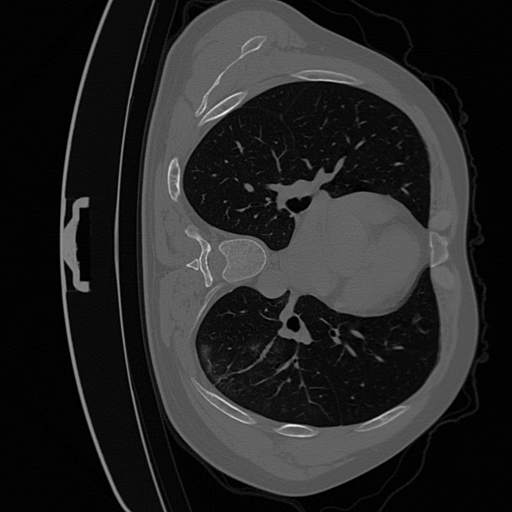

In [19]:
from PIL import Image
image = batch["original_images"][0]
Image.fromarray(image)

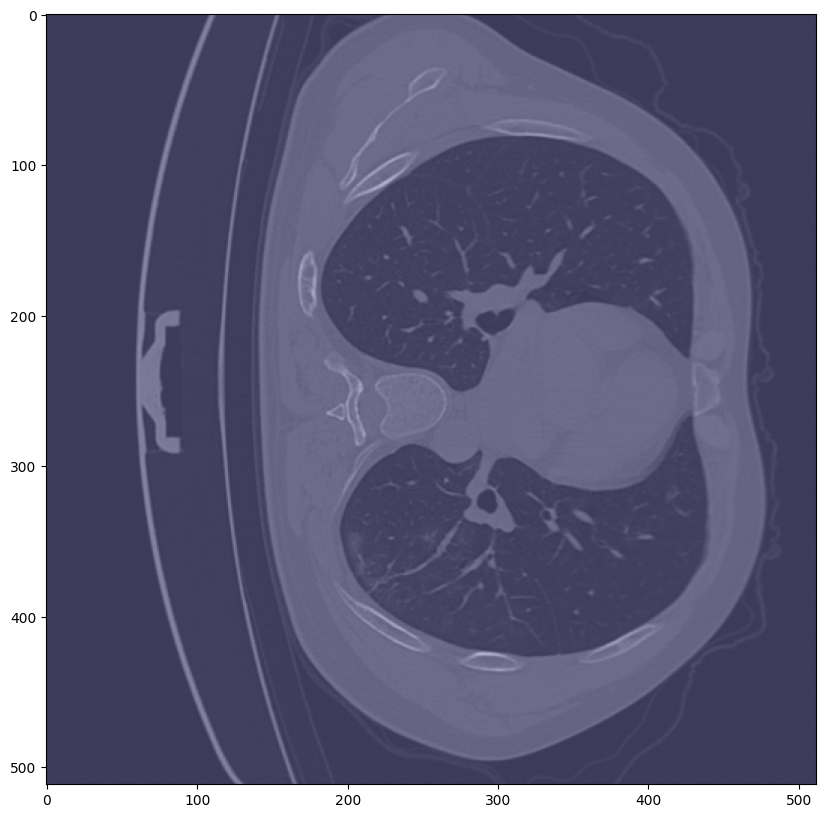

In [22]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = predicted_segmentation_maps[0].cpu().numpy()

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare to the ground truth:

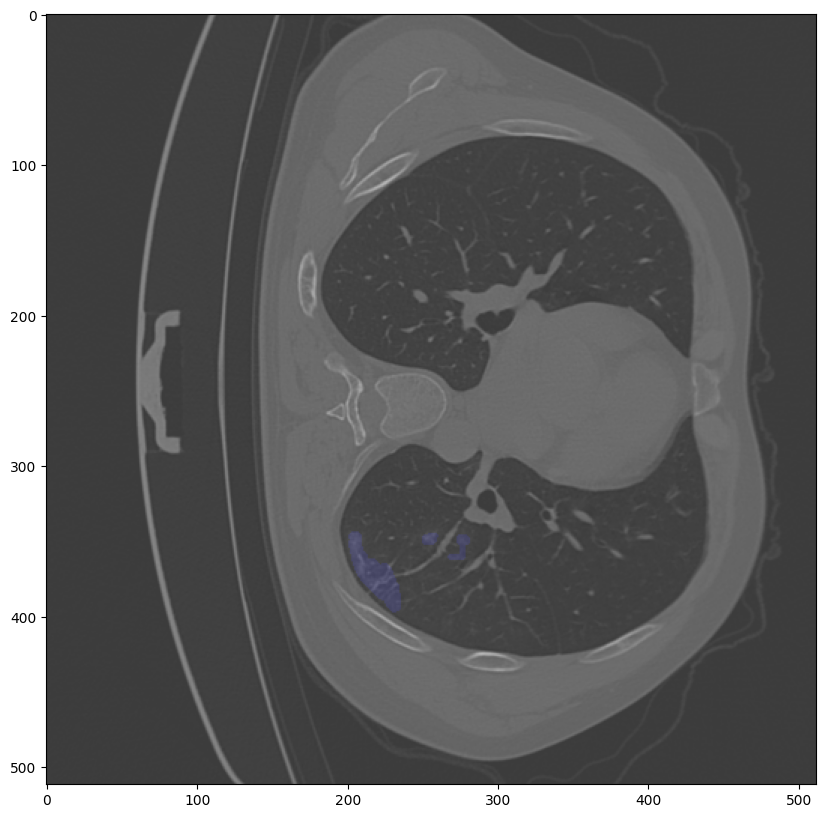

In [23]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = batch["original_segmentation_maps"][0]

color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = image * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()